<a href="https://colab.research.google.com/github/Shreya-Mendi/XAI/blob/Colab/ML_Court/machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb)

# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [20]:
!pip install dice-ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.2 MB/s eta 0:00:00


In [21]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Load Dataset
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean and preprocess
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.value_counts())
print(y_train.value_counts())
print(X_test.value_counts())
print(y_test.value_counts())

# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))


age  workclass  education  education-num  marital-status  occupation  relationship  race  sex  capital-gain  capital-loss  hours-per-week  native-country
39   2          11         9              2               2           0             4     1    0             0             40              38                23
37   2          11         9              2               2           0             4     1    0             0             40              38                19
32   2          11         9              2               2           0             4     1    0             0             40              38                19
29   2          11         9              2               2           0             4     1    0             0             40              38                19
47   2          11         9              2               2           0             4     1    0             0             40              38                19
                                              

Prediction for Jane Dow (Loan Eligibility): Denied


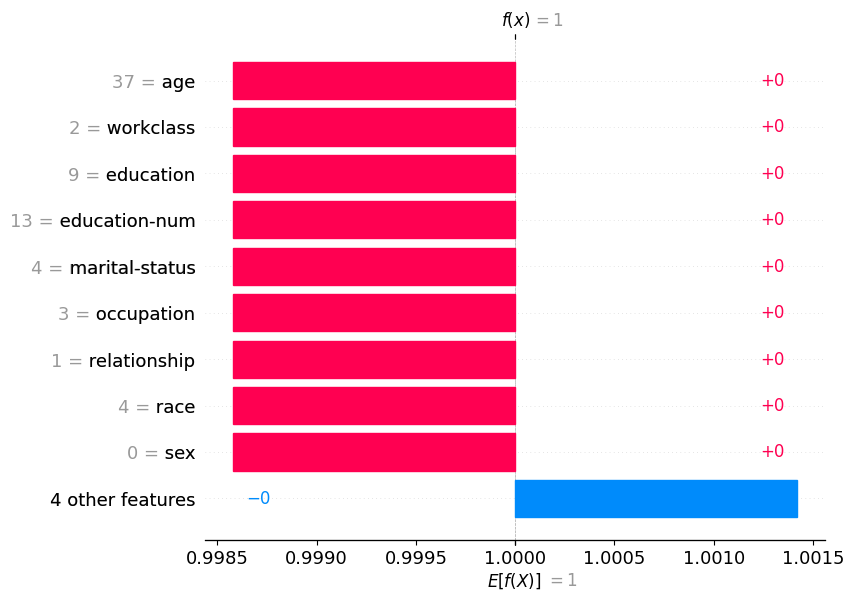

age: 0.0000
workclass: 0.0000
education: 0.0000
education-num: 0.0000
marital-status: 0.0000
occupation: 0.0000
relationship: 0.0000
race: 0.0000
sex: 0.0000
capital-gain: 0.0000
capital-loss: 0.0000
hours-per-week: 0.0000
native-country: 0.0000


ValueError: Got predict_proba of shape (36177, 1), but need classifier with two classes.

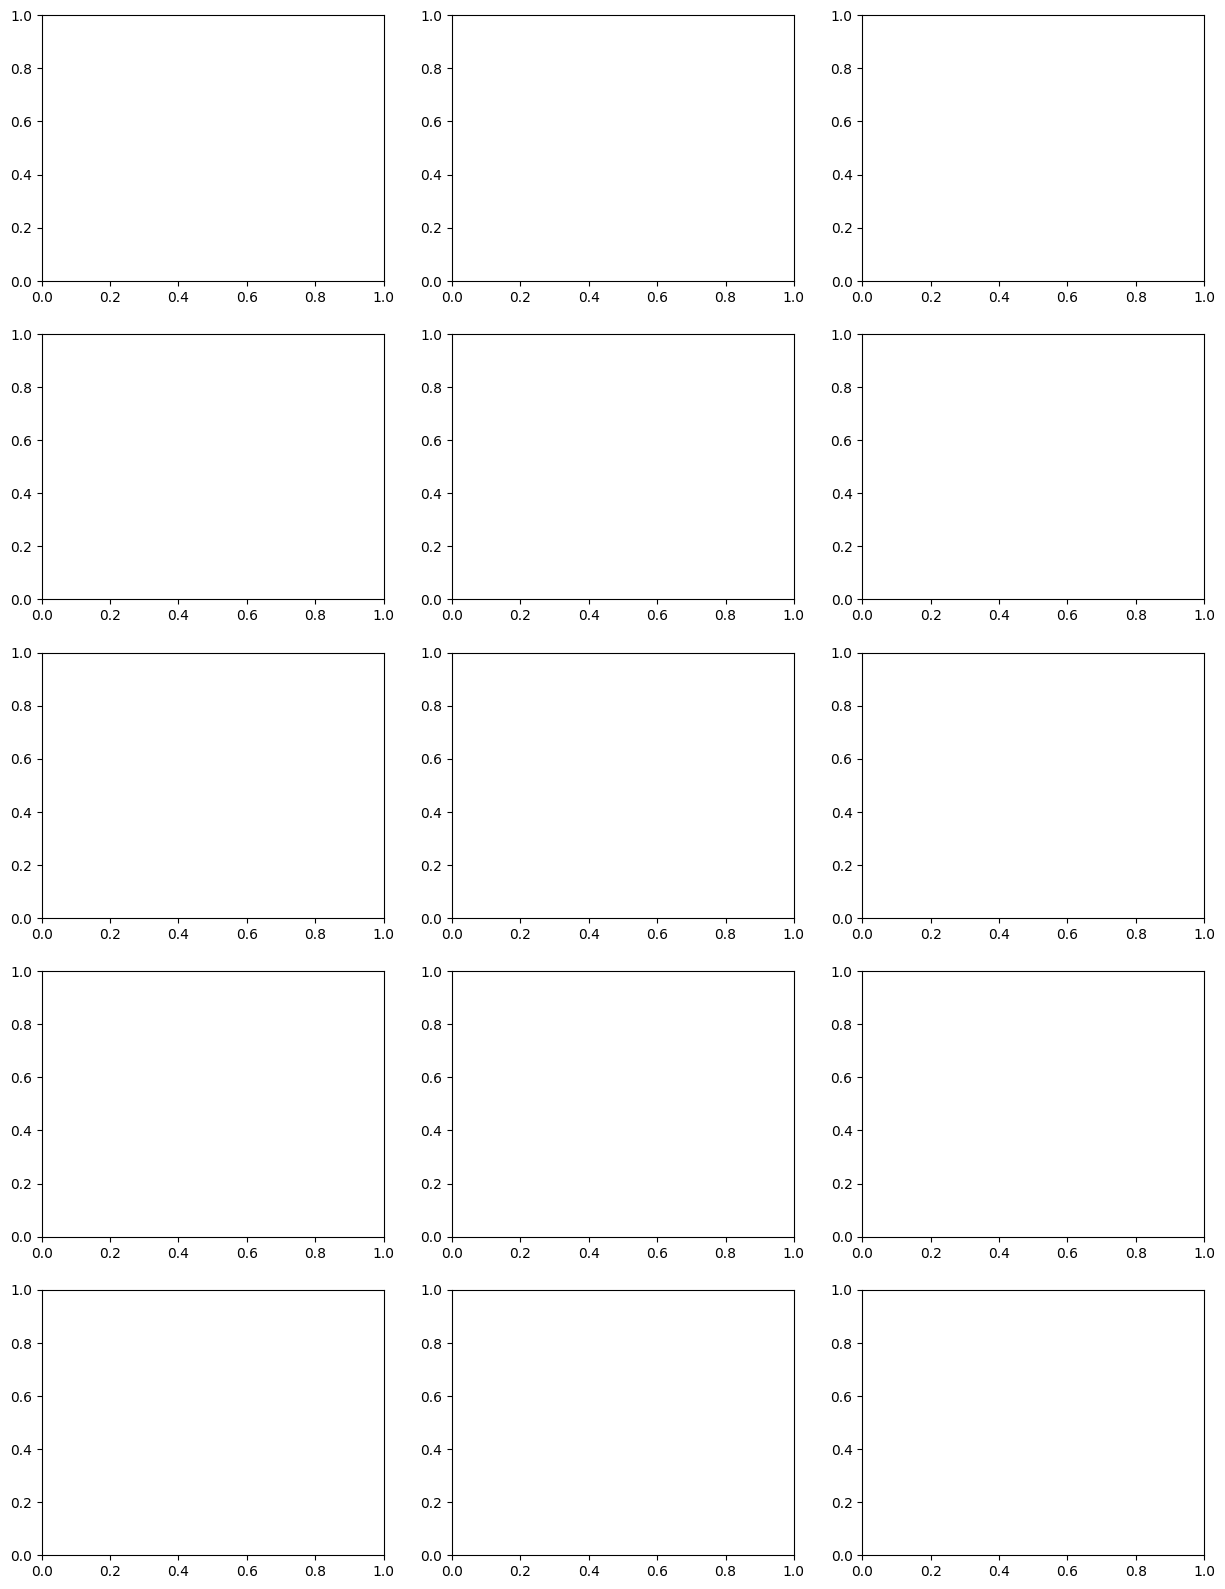

In [29]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}


jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")

# 🔍 SHAP Explanation
explainer_shap = shap.TreeExplainer(model_adult)
shap_values = explainer_shap.shap_values(jane_df)

if isinstance(shap_values, list) and len(shap_values) > 1:
    # Multi-class case → pick class 1 (>50K)
    shap_values_class = shap_values[1][0]
    base_value = explainer_shap.expected_value[1]
else:
    # Binary collapsed case → shap gives single array
    shap_values_class = shap_values[0]
    base_value = explainer_shap.expected_value

shap.waterfall_plot(shap.Explanation(
    values=shap_values_class,
    base_values=base_value,
    data=jane_df.iloc[0].values,
    feature_names=X_train.columns.tolist()
))

importances = model_adult.feature_importances_
for f, imp in zip(X_train.columns, importances):
    print(f"{f}: {imp:.4f}")

# Get all feature names
all_features = X_train.columns.tolist()

# Create subplots grid (adjust rows/cols depending on number of features)
n_features = len(all_features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))


fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
ax = ax.flatten()[:n_features]

# Plot ICE for all features
PartialDependenceDisplay.from_estimator(
    model_adult,
    X_train,
    features=all_features,
    kind="both",   # ICE instead of PDP
    subsample=50,        # optional: sample rows for speed
    random_state=42,
    ax=ax
)

plt.suptitle("ICE Plots for All Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


The SHAP plot shows that all aspects of Jane's profile are hinting highly towards a rejection. The feature importance shows that there is equal and no importance given to any of the features. The ICE plot show the same results in plots.

The SHAP and ICE plots demonstrate the model is fundamentally flawed, not that it is making a fair decision.

The SHAP plot shows no feature had any impact on the outcome. This is because the model's base prediction is rejection, and no feature is powerful enough to change that.

The ICE plot confirms this by showing no features were used to make the decision for Jane Dow.

Both plots serve as irrefutable evidence that the model is incapable of making a fair decision. The model is a systemic failure, not an issue of poor reasoning, as it was trained on a single-class dataset and knows no other outcome.

When looking at the training and test datasets we see that there is a huge bias and all the datasets are from the same class("rejected") . Hence no matter the profile of the person,they will get rejected by the system for their loan. This shows that the model is majorly flawed and is not recommended for this usecase unless the dataset is broadened.

